In [34]:
import pandas as pd
import numpy as np
import warnings

import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

pd.options.display.max_rows = None
warnings.filterwarnings("ignore")

In [21]:
df = pd.read_csv('scanner_data.csv')
#display(df.style.set_caption("Background gradient applied to all columns").background_gradient())
df.head(5)

,Unnamed: 0,Date,Customer_ID,Transaction_ID,SKU_Category,SKU,Quantity,Sales_Amount
0,1,02/01/2016,2547,1,X52,0EM7L,1.0,3.13
1,2,02/01/2016,822,2,2ML,68BRQ,1.0,5.46
2,3,02/01/2016,3686,3,0H2,CZUZX,1.0,6.35
3,4,02/01/2016,3719,4,0H2,549KK,1.0,5.59
4,5,02/01/2016,9200,5,0H2,K8EHH,1.0,6.88


In [22]:
df.isna().sum()

Unnamed: 0        0
Date              0
Customer_ID       0
Transaction_ID    0
SKU_Category      0
SKU               0
Quantity          0
Sales_Amount      0
dtype: int64

But we’ll need to clean up the data and format the dates before we can make use of it. We’ll also want to put transactions performed by the same customer on the same date in a single row since our demonstration will be based on transaction date, quantity, and sales amount, rather than product type. Here’s how:

In [23]:
df.drop(['Unnamed: 0'], axis = 1)

df.Date = pd.to_datetime(df.Date, format='%d/%m/%Y')

df.duplicated(["Date","Customer_ID"]).sum()

68979

In [24]:
df = pd.DataFrame(df.groupby(["Date","Customer_ID"]).agg({'Transaction_ID':max

                                                          , 'SKU_Category':max, 'SKU':max, 'Quantity': sum

                                                          , 'Sales_Amount':sum})).reset_index()


In [25]:
df.head()

,Date,Customer_ID,Transaction_ID,SKU_Category,SKU,Quantity,Sales_Amount
0,2016-01-02,3,90,TW8,Y1M2E,4.0,10.92
1,2016-01-02,178,84,R6E,HO1M5,2.0,58.99
2,2016-01-02,195,107,LGI,VY2UB,2.0,13.10
3,2016-01-02,343,134,XG4,ZSVWE,1.0,6.75
4,2016-01-02,399,136,P42,XJLWY,2.0,10.43


# To run a cohort analysis, we’ll need to: 

Split the data into groups that can be analyzed on the basis of time
Assign a cohort index for each transaction
Create two new columns
The following code shows how to apply a simple lambda function to the date column in order to: 

Create the tx_month column 
Transform tx_month to get the minimum value of tx_month per customer 
Assign tx_month per customer to the acq_month column:

In [27]:
import datetime as dt
df['tx_month'] = df['Date'].apply(lambda x: dt.date(x.year, x.month,1))

df['acq_month'] = df.groupby('Customer_ID')['tx_month'].transform('min')

df.loc[df['tx_month'] != df['acq_month']].head()

,Date,Customer_ID,Transaction_ID,SKU_Category,SKU,Quantity,Sales_Amount,tx_month,acq_month
4701,2016-02-01,50,5004,W41,ZWFSY,5.0,2.86,2016-02-01,2016-01-01
4702,2016-02-01,91,4976,2ML,68BRQ,1.0,5.79,2016-02-01,2016-01-01
4709,2016-02-01,366,4852,J4R,VGIW5,2.0,15.64,2016-02-01,2016-01-01
4720,2016-02-01,889,4900,TEU,A233P,2.0,11.87,2016-02-01,2016-01-01
4723,2016-02-01,1115,4933,YMJ,JNWFX,1.0,7.43,2016-02-01,2016-01-01


The cohort index for the row is the time difference between tx_month and acq_month, and the difference between the dates is calculated by a function that adds 1 to the result in order to start the cohorts at 1 rather than 0 (ie., a transaction made in the same month as the acquisition):

In [28]:
def diff_month(x):

    d1 = x['tx_month']

    d2 = x["acq_month"]

    return ((d1.year - d2.year) * 12 + d1.month - d2.month)+1


df['cohort_idx'] = df.apply(lambda x: diff_month(x), axis=1)

df.head()

,Date,Customer_ID,Transaction_ID,SKU_Category,SKU,Quantity,Sales_Amount,tx_month,acq_month,cohort_idx
0,2016-01-02,3,90,TW8,Y1M2E,4.0,10.92,2016-01-01,2016-01-01,1
1,2016-01-02,178,84,R6E,HO1M5,2.0,58.99,2016-01-01,2016-01-01,1
2,2016-01-02,195,107,LGI,VY2UB,2.0,13.10,2016-01-01,2016-01-01,1
3,2016-01-02,343,134,XG4,ZSVWE,1.0,6.75,2016-01-01,2016-01-01,1
4,2016-01-02,399,136,P42,XJLWY,2.0,10.43,2016-01-01,2016-01-01,1


# 4–Calculate Retention Rates
We can now make some interesting calculations, such as finding out how many unique customers were acquired per month per cohort by setting the cohort_idx per row. The function below takes a dataframe, a variable to be grouped, and a function to be used as aggregate data, and returns two matrices:

The first shows the absolute value per cohort per month, with the function applied over the variable and passed as an argument,
The other represents the results as a percentage:

In [29]:
def get_cohort_matrix(data, var='Customer_ID', fun=pd.Series.nunique):

    cd = data.groupby(['acq_month', 'cohort_idx'])[var].apply(fun).reset_index()

    cc = cd.pivot_table(index = 'acq_month',

                        columns = 'cohort_idx',

                        values = var)

    cs = cc.iloc[:,0]

    retention = cc.divide(cs, axis = 0)

    retention = retention.round(3) * 100

    return cc, retention

In [30]:
cc, retention = get_cohort_matrix(df)

cc

cohort_idx,1,2,3,4,5,6,7,8,9,10,11,12
acq_month,,,,,,,,,,,,
2016-01-01,3396.0,1306.0,1025.0,597.0,266.0,197.0,152.0,137.0,90.0,56.0,41.0,40.0
2016-02-01,2221.0,478.0,291.0,147.0,95.0,68.0,68.0,57.0,22.0,18.0,14.0,NaN
2016-03-01,2642.0,746.0,651.0,600.0,530.0,521.0,530.0,512.0,513.0,532.0,NaN,NaN
2016-04-01,2527.0,728.0,633.0,553.0,566.0,595.0,566.0,567.0,581.0,NaN,NaN,NaN
2016-05-01,2626.0,626.0,559.0,505.0,566.0,551.0,521.0,523.0,NaN,NaN,NaN,NaN
2016-06-01,1569.0,278.0,274.0,280.0,278.0,277.0,300.0,NaN,NaN,NaN,NaN,NaN
2016-07-01,1213.0,172.0,183.0,189.0,182.0,201.0,NaN,NaN,NaN,NaN,NaN,NaN
2016-08-01,1060.0,163.0,138.0,143.0,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-09-01,1625.0,309.0,263.0,297.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
# https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar

def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts


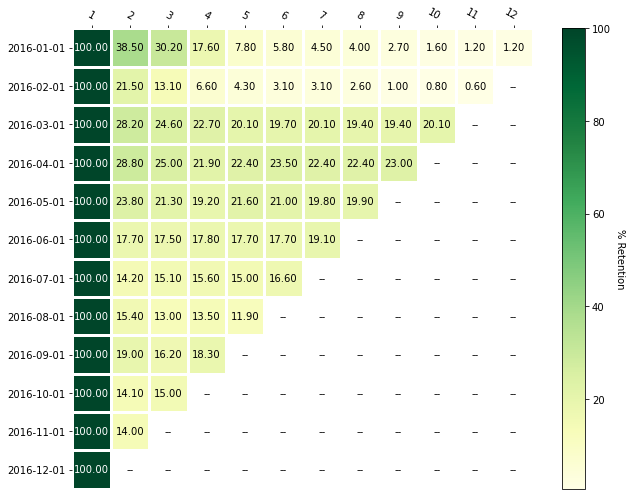

In [41]:
import matplotlib
fig, ax =  plt.subplots(figsize = (9,7))
im, cbar = heatmap(retention, retention.index, retention.columns, ax=ax,
                   cmap="YlGn", cbarlabel="% Retention")
texts = annotate_heatmap(im, valfmt="{x:.2f}")

fig.tight_layout()